In [39]:
!pip install scikit-learn matplotlib seaborn pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [62]:

file_path = "SupplyChainEmissionFactorsforUSIndustriesCommodities2015_Summary.csv"  # adjust path in Colab
try:
    df = pd.read_csv(file_path)
    print(" Dataset loaded successfully.")
    display(df.head())
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found. Please ensure the file is in the correct directory.")
    df = pd.DataFrame() # Create an empty dataframe to prevent further errors

 Dataset loaded successfully.


,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,111CA,Farms,carbon dioxide,"kg/2018 USD, purchaser price",Supply Chain Emission Factors without Margins,0.041,0.465,NaN,4,2,1,4,1
1,111CA,Farms,methane,"kg/2018 USD, purchaser price",0.023,0.000,0.023,NaN,3,2,1,1,1
2,111CA,Farms,nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,2,1,4,1
3,111CA,Farms,other GHGs,"kg CO2e/2018 USD, purchaser price",0.004,0.000,0.004,NaN,3,2,1,4,1
4,113FF,"Forestry, fishing, and related activities",carbon dioxide,"kg/2018 USD, purchaser price",0.184,0.017,0.201,NaN,4,2,1,4,1


In [63]:

df = df.drop(columns=["Unnamed: 7"])
target_column = "Supply Chain Emission Factors with Margins"
X = df.drop(columns=[target_column])
y = df[target_column]
X = pd.get_dummies(X, drop_first=True)

X.shape, y.shape

((264, 225), (264,))

In [56]:

df = df.drop(columns=["Unnamed: 7"], errors="ignore")
columns_to_numeric = [
    "Supply Chain Emission Factors without Margins",
    "Margins of Supply Chain Emission Factors",
    "Supply Chain Emission Factors with Margins",
    "DQ ReliabilityScore of Factors without Margins",
    "DQ TemporalCorrelation of Factors without Margins",
    "DQ GeographicalCorrelation of Factors without Margins",
    "DQ TechnologicalCorrelation of Factors without Margins",
    "DQ DataCollection of Factors without Margins"
]

for col in columns_to_numeric:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")
target_column = "Supply Chain Emission Factors with Margins"
df = df.dropna(subset=[target_column])
y = df[target_column]
X = df.drop(columns=[target_column])
categorical_cols = ["Industry Code", "Industry Name", "Substance", "Unit"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X = X.dropna(how="all")

print("After cleaning:")
print("X shape:", X.shape)
print("y shape:", y.shape)

After cleaning:
X shape: (264, 141)
y shape: (264,)


In [43]:
from sklearn.model_selection import train_test_split
if X.shape[0] > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Training set shape:", X_train.shape, y_train.shape)
    print("Test set shape:", X_test.shape, y_test.shape)
else:
    print("ERROR: No rows in X. Check preprocessing.")

Training set shape: (211, 141) (211,)
Test set shape: (53, 141) (53,)


In [54]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
print("Missing values handled.")


Missing values handled.


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {'model': model, 'predictions': preds}

print("Models trained successfully!")


Models trained successfully!


In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

metrics = {}

for name, res in results.items():
    preds = res['predictions']
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
import pandas as pd
metrics_df = pd.DataFrame(metrics).T
print("Model Performance:")
print(metrics_df)


Model Performance:
                       RMSE       MAE        R2
Linear Regression  0.008525  0.005701  0.996671
Decision Tree      0.020567  0.005698  0.980623
Random Forest      0.026150  0.006065  0.968673


In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Cross-Validation R²:", grid_search.best_score_)

best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation R²: 0.7329867586886567


In [51]:

rf_preds = best_rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f" Tuned Random Forest -> RMSE: {rf_rmse:.3f}, MAE: {rf_mae:.3f}, R²: {rf_r2:.3f}")


 Tuned Random Forest -> RMSE: 0.027, MAE: 0.005, R²: 0.966


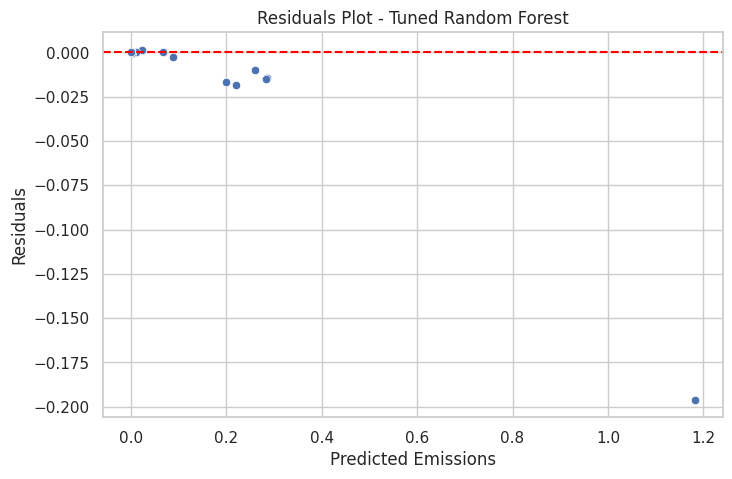

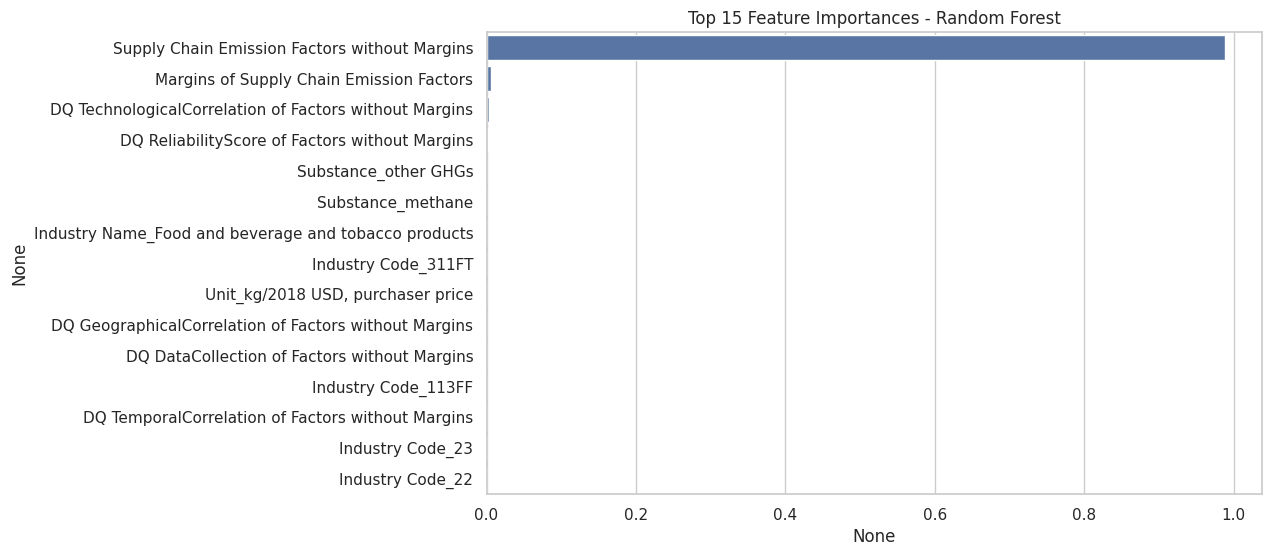

In [68]:
residuals = y_test - rf_preds
plt.figure(figsize=(8,5))
sns.scatterplot(x=rf_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Emissions")
plt.ylabel("Residuals")
plt.title("Residuals Plot - Tuned Random Forest")
plt.show()
feature_importances = pd.Series(best_rf.feature_importances_, index=pd.get_dummies(df.drop(columns=[target_column]), columns=categorical_cols, drop_first=True).columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances[:15], y=feature_importances.index[:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

In [53]:
import joblib
joblib.dump(best_rf, "best_random_forest_model.pkl")
print("Best Random Forest model saved as best_random_forest_model.pkl")


Best Random Forest model saved as best_random_forest_model.pkl
